In [1]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
You should consider upgrading via the '/home/isadorasalles/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [8]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import operator
from sklearn.preprocessing import MinMaxScaler
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

from preprocessing import preprocess
from cluster import *
from baseline import train_val_split, baseline_model, train_model, print_metrics

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
labels_path = '../labels/'
results_path = '../results/'
clustering_method = 'spectral_clustering'

data_path = '../data/'
course = 'dsp_001'
norm = 'unit'

MODEL_PATH += course + '/'
labels_path += course + '/' + clustering_method + '/'
results_path += course + '/shap/' + clustering_method + '/' + norm + '/'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
if not os.path.exists(results_path):
    os.makedirs(results_path)

path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
# hard_fail = path + 'feature_labels.csv'
percentile = 0.4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, feature_types, metadata, norm)

In [5]:
# Concat features & labels
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)

In [6]:
labels = np.loadtxt(labels_path+'baseline_'+str(norm)+'_norm_perc_0.4_gamma_0.6.txt', dtype=int)

In [7]:
def get_instance_explanations(c, instances):
    idx = np.where(labels == c)[0]
    X_train = X[idx]
    Y_train = Y[idx]
    x_train, x_val, y_train, y_val = train_val_split(X_train, Y_train)

    baseline_params = {
    'name': 'baseline-32u-1l',
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['binary_accuracy'],
    'epochs': 20,
    'batch_size': 64,
    'verbose': 1
    }
    baseline = baseline_model()

    baseline.load_weights(MODEL_PATH + 'baseline_'+str(norm)+'_norm_classifier_for_cluster_'+str(c))

    baseline.predict(x_train)
    explainer = shap.DeepExplainer(baseline, x_train)

    shap_values = explainer.shap_values(x_train[instances])
    
    shap_mean_values = []
    shap_mean_values.append(np.mean(shap_values[0], axis=1))
    
    return explainer, shap_values, shap_mean_values, instances, y_train

def get_feature_importance(shap_mean_values):

    feature_type_mean_importance = {}

    for i in range(len(feature_names)):
        d = pd.DataFrame({i: np.absolute(shap_mean_values[0][:, i])})
        feature_type_mean_importance[feature_names[i]] = np.mean(d[i])
 
    return dict(sorted(feature_type_mean_importance.items(), key=operator.itemgetter(1),reverse=True))

Getting explanations for cluster 0
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.


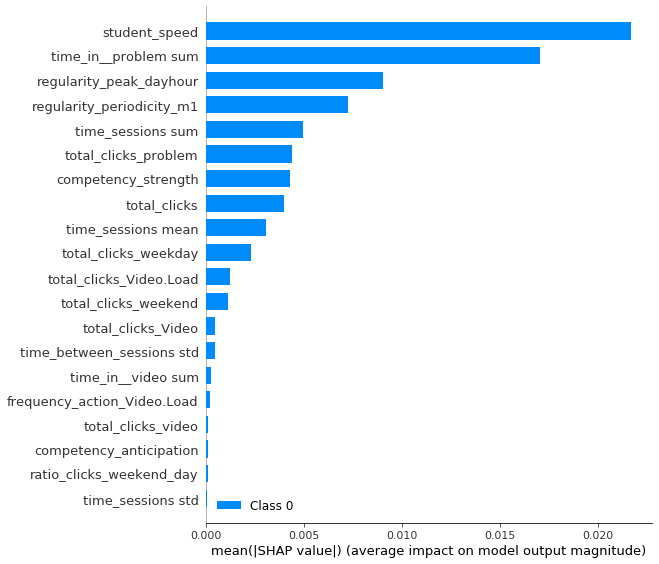

Getting explanations for cluster 1


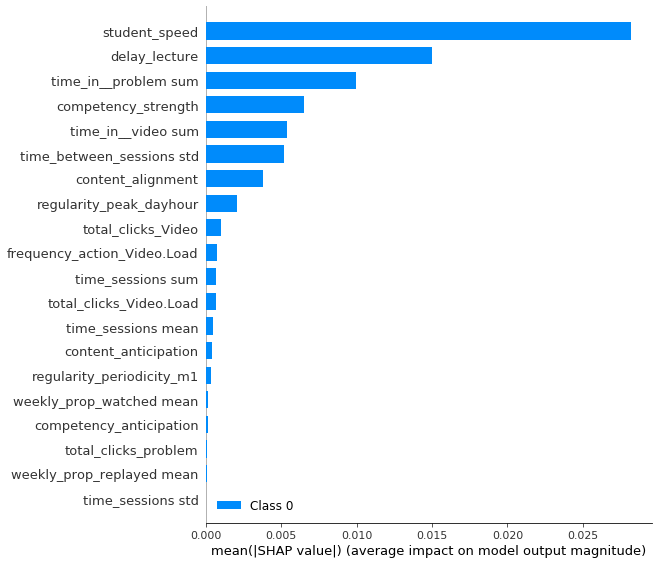

Getting explanations for cluster 2


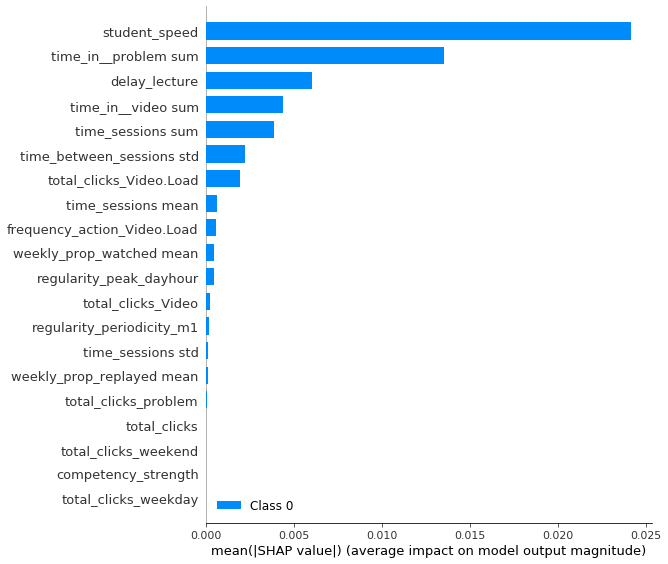

Getting explanations for cluster 3


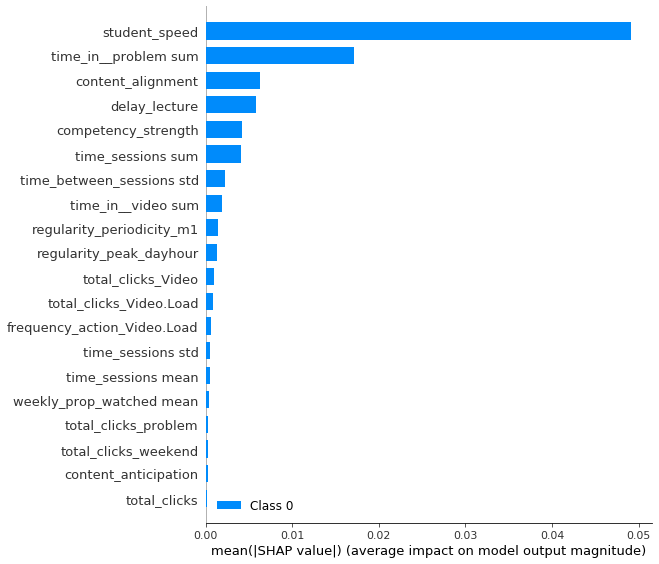

Getting explanations for cluster 4


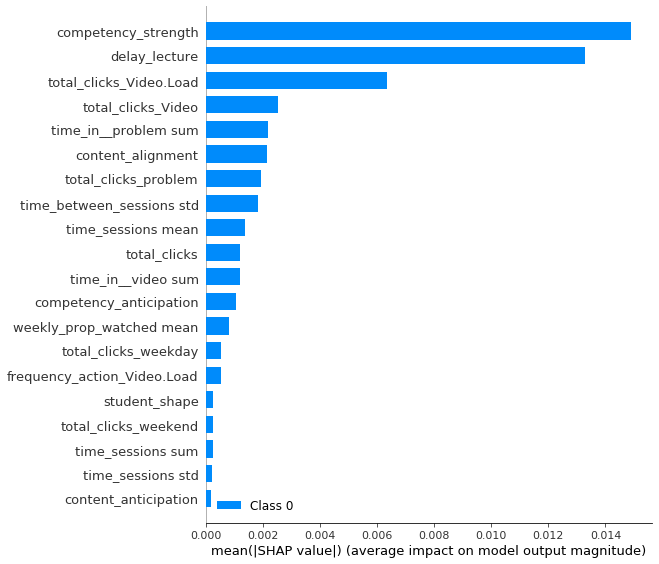

In [9]:
df_importance = pd.DataFrame()
for c in np.unique(labels):
    print("Getting explanations for cluster {0}".format(c))
    df = pd.read_csv('../results/'+course+'/lime/'+clustering_method+'/'+norm+'/lime_cluster_'+str(c)+'.csv', index_col=0)
    instances = df['exp number'].tolist()
    explainer, shap_values, shap_mean_values, instances, y_train = get_instance_explanations(c, instances)
    shap.summary_plot(shap_mean_values, feature_names=feature_names)
        
    aux = pd.DataFrame(get_feature_importance(shap_mean_values), index=[c])
    df_importance = pd.concat([df_importance, aux])

In [10]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0], feature_names=feature_names
)

In [11]:
df_importance.to_csv(results_path+'features_importance.csv', index=False)